In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time

In [2]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


# Import network, layers and functions

In [3]:
from network import Sequential,layers
from layers import conv2d,max_pool,flatten,dense,dropout
import functions
import numpy as np

# Make Sequential Model

In [4]:
model=Sequential()

In [5]:
model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu,input_shape=(32,32,3)))
# model.add(conv2d(num_kernels=32,kernel_size=3,activation=functions.relu))
model.add(max_pool())              #TODO- ADD ACTIVATION LAYER LATER, conv2d can echo
model.add(dropout(0.1))
model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
# model.add(conv2d(num_kernels=64,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.2))
model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
# model.add(conv2d(num_kernels=128,kernel_size=3,activation=functions.relu))
model.add(max_pool())
model.add(dropout(0.3))
model.add(flatten())
model.add(dense(512,activation=functions.relu))
model.add(dropout(0.4))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [6]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Name (type)                     Output Shape             Activation        Param #
input_layer (InputLayer)       (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 32, 32, 32)         relu             896
__________________________________________________________________________________________
max_pool (max_pool)            (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
dropout (dropout)              (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 16, 16, 64)         relu             18496
_______________________________________________________________________

# Compile model with optimizer, loss and lr

In [7]:
model.compile(optimizer=functions.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

# Reload saved model weights

In [8]:
model.load_weights("cifar.dump")

# Train model

In [9]:
losses=[]
train_acc=[]

In [10]:
def validate(vdsz=1000):
    dvme=len(dt.test_images)//vdsz
    acc=0
    cross_entropy_loss=0
    for smpl in range(0,len(dt.test_images),vdsz):
        print("\rCalculating Validation acc...",dvme-smpl//vdsz,end=' ')
        inp = dt.test_images[smpl:smpl+vdsz].reshape(-1,32,32,3)
        y_inp = dt.test_labels[smpl:smpl+vdsz]
        logits=model.predict(inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc+=100*(ans==cor).mean()
        cross_entropy_loss+=model.loss(logits,labels=y_inp).mean()*10
    print("\rValidation Acc: {:.3f} %        Val loss: {:.8f}".format(acc/dvme,cross_entropy_loss/dvme))
    logits=model.free(inp[:1],y_inp[:1])

In [11]:
validate()

Validation Acc: 71.550 %        Val loss: 1.08295267


In [12]:
def run():
    st=0
    btsz=128
    acc_tn=0
    _cc=0
    loss_tn=0
    pre_tm=0
    while st<=50000:
        sam_tm=time()
        perc=st/500
        ck=np.random.randint(0,50000-btsz)
        inp,y_inp=dt.batch_gen(ck=ck,size=btsz)
        logits=model.fit(inp,y_inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc=100*(ans==cor).mean()
        cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()*10
        acc_tn+=acc
        _cc+=1
        loss_tn+=cross_entropy_loss
        acc=acc_tn/_cc
        loss_=loss_tn/_cc
        losses.append(loss_)
        train_acc.append(acc)
#         if acc>=63:
#             model.learning_rate=1e-4
#         elif acc>=52:
#             model.learning_rate=1e-4
#         elif acc>=62:
#             model.learning_rate=1e-4
        sam_tm=time()-sam_tm
        pre_tm+=sam_tm
        sam_tm=pre_tm/_cc
        rem_sam=(50000-st)/btsz
        eta=int(rem_sam*sam_tm)
        print("\rProgress: {:.2f} %    Acc: {:.3f} %    loss: {:.6f}     Sample time: {:.3f}s    ETA: {}:{}s    _".format(perc,acc,loss_,sam_tm,eta//60,eta%60),end='')
        st+=btsz
    print("")

In [13]:
epochs=4
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 42.475 %    loss: 1.591531     Sample time: 0.888s    ETA: 0:0s    __
Epoch time: 5:47s
Validation Acc: 56.250 %        Val loss: 1.42187648
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 58.582 %    loss: 1.155724     Sample time: 0.874s    ETA: 0:0s    __
Epoch time: 5:41s
Validation Acc: 62.280 %        Val loss: 1.23454864
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 66.920 %    loss: 0.936791     Sample time: 0.873s    ETA: 0:0s    __
Epoch time: 5:41s
Validation Acc: 68.600 %        Val loss: 1.05306408
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 68.438 %    loss: 0.887676     Sample time: 0.982s    ETA: 0:0s    __
Epoch time: 6:24s
Validation Acc: 69.240 %        Val loss: 1.04585591


In [30]:
epochs=4
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 66.250 %    loss: 0.955770     Sample time: 0.821s    ETA: 0:0s    __
Epoch time: 5:21s
Validation Acc: 68.400 %        Val loss: 1.11216823
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 68.866 %    loss: 0.880217     Sample time: 0.859s    ETA: 0:0s    __
Epoch time: 5:35s
Validation Acc: 69.110 %        Val loss: 1.11931423
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 71.735 %    loss: 0.807851     Sample time: 5.357s    ETA: 0:3s    ___
Epoch time: 34:54s
Validation Acc: 70.370 %        Val loss: 1.14421095
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 73.062 %    loss: 0.770726     Sample time: 0.677s    ETA: 0:0s    __
Epoch time: 4:24s
Validation Acc: 71.550 %        Val loss: 1.08295267


In [13]:
epochs=4
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 74.596 %    loss: 0.738876     Sample time: 0.656s    ETA: 0:0s    __
Epoch time: 4:16s
Validation Acc: 72.600 %        Val loss: 1.04682798
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 75.829 %    loss: 0.704823     Sample time: 0.639s    ETA: 0:0s    __
Epoch time: 4:9s
Validation Acc: 73.760 %        Val loss: 1.03022095
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 76.517 %    loss: 0.680215     Sample time: 0.643s    ETA: 0:0s    __
Epoch time: 4:11s
Validation Acc: 72.580 %        Val loss: 1.11417020
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 77.769 %    loss: 0.656916     Sample time: 0.944s    ETA: 0:0s    __
Epoch time: 6:9s
Validation Acc: 73.800 %        Val loss: 1.21868806


In [21]:
epochs=4
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 77.272 %    loss: 0.662957     Sample time: 0.744s    ETA: 0:0s    __
Epoch time: 4:51s
Validation Acc: 74.660 %        Val loss: 0.99844986
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 78.810 %    loss: 0.627840     Sample time: 0.641s    ETA: 0:0s    __
Epoch time: 4:10s
Validation Acc: 73.760 %        Val loss: 1.15088141
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 78.646 %    loss: 0.628948     Sample time: 0.649s    ETA: 0:0s    __
Epoch time: 4:13s
Validation Acc: 73.270 %        Val loss: 1.14605225
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 79.324 %    loss: 0.617089     Sample time: 0.733s    ETA: 0:0s    __
Epoch time: 4:46s
Validation Acc: 75.510 %        Val loss: 1.09738669


In [13]:
epochs=4
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("Epoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    validate()
    dt.shuffle_datasets()

EPOCH: 1 / 4
Progress: 99.84 %    Acc: 74.596 %    loss: 0.738876     Sample time: 0.656s    ETA: 0:0s    __
Epoch time: 4:16s
Validation Acc: 72.600 %        Val loss: 1.04682798
EPOCH: 2 / 4
Progress: 99.84 %    Acc: 75.829 %    loss: 0.704823     Sample time: 0.639s    ETA: 0:0s    __
Epoch time: 4:9s
Validation Acc: 73.760 %        Val loss: 1.03022095
EPOCH: 3 / 4
Progress: 99.84 %    Acc: 76.517 %    loss: 0.680215     Sample time: 0.643s    ETA: 0:0s    __
Epoch time: 4:11s
Validation Acc: 72.580 %        Val loss: 1.11417020
EPOCH: 4 / 4
Progress: 99.84 %    Acc: 77.769 %    loss: 0.656916     Sample time: 0.944s    ETA: 0:0s    __
Epoch time: 6:9s
Validation Acc: 73.800 %        Val loss: 1.21868806


In [31]:
# losses=losses[::2]
# train_acc=train_acc[::2]

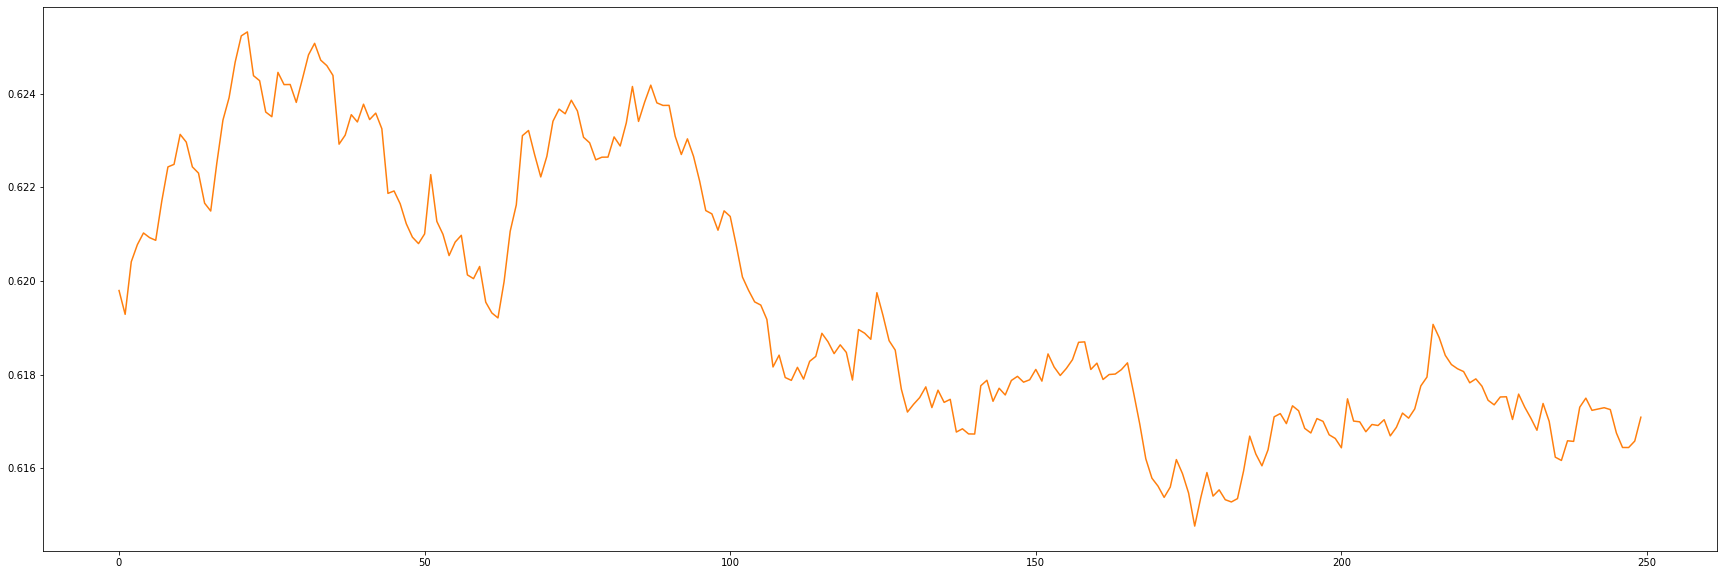

In [24]:
plt.figure(figsize=(30,10))
plt.plot(losses[-250:],color='#ff7f0e')
plt.show()

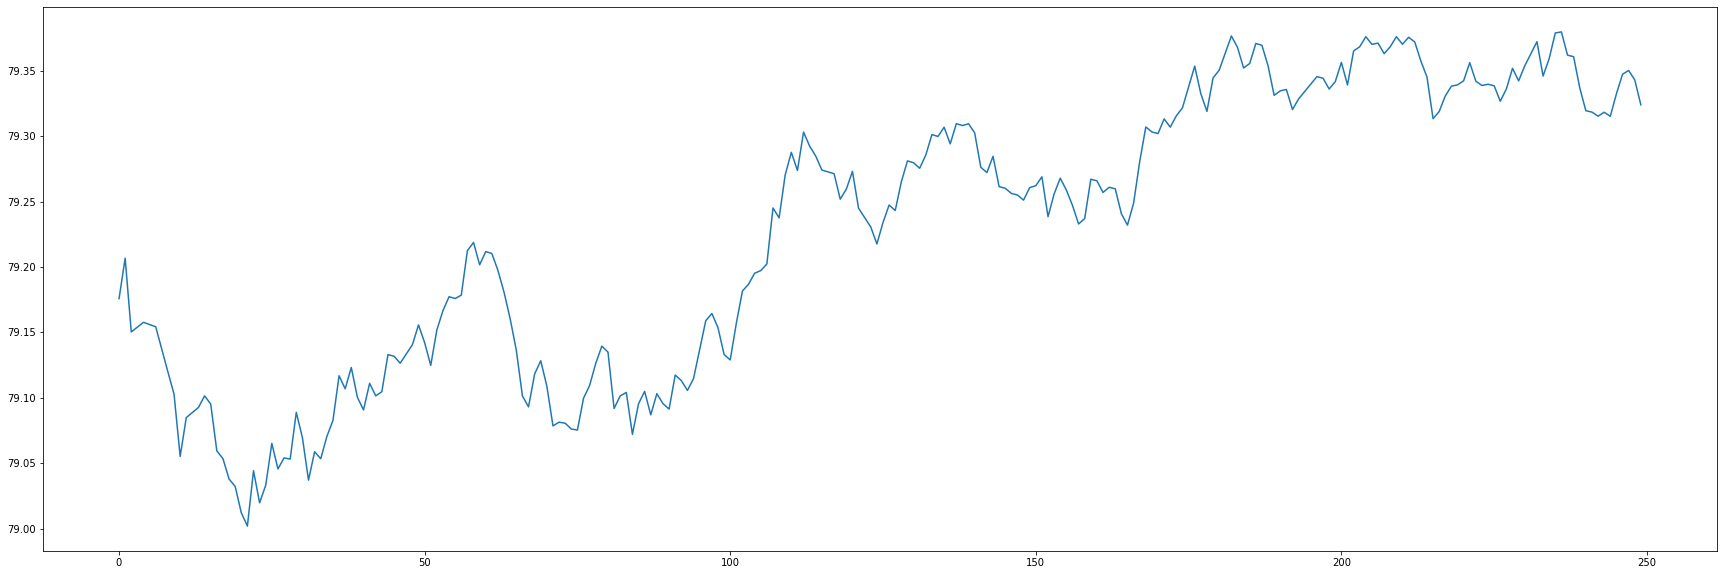

In [25]:
plt.figure(figsize=(30,10))
plt.plot(train_acc[-250:])#,color='#ff7f0e')
plt.show()

In [26]:
model.save_weights("cifar.dump")

Prediction:  automobile 
Correct answer:  automobile


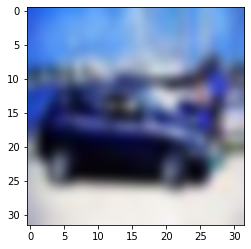

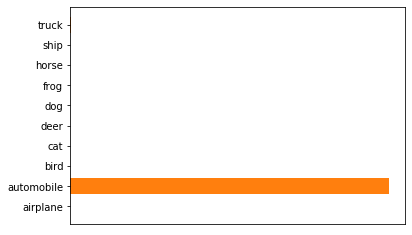

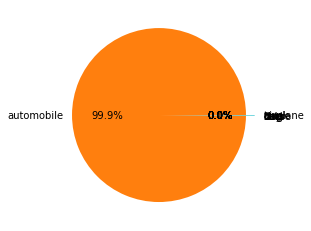

In [39]:
ck=np.random.randint(0,10000)
# inp,y_inp=dt.batch_gen(size=1,ck=ck)
inp = dt.test_images[ck:ck+1].reshape(-1,32,32,3)
y_inp = dt.test_labels[ck:ck+1]
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
logits=logits[0]
print("Prediction: ",dt.names[int(ans[0])],"\nCorrect answer: ",dt.names[int(cor[0])])
plt.imshow(inp[0],interpolation='bicubic')
plt.show()
plt.barh(range(len(logits)),logits,color='#ff7f0e')
plt.yticks(range(len(logits)),dt.names)
plt.xticks([])
plt.show()
explode=np.zeros(10)
explode[ans]=0.1
plt.pie(logits,labels=dt.names,autopct='%1.1f%%',explode=explode)
plt.show()

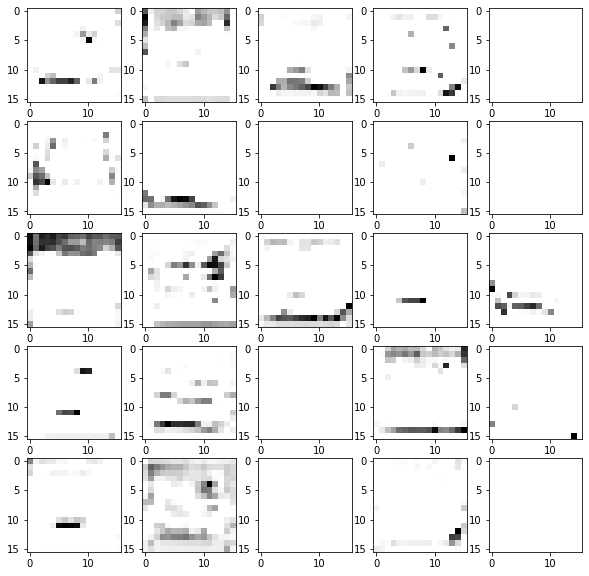

In [40]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[3].z_out[0].transpose(2,0,1)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')